In [3]:
"""
Constant-pressure, adiabatic kinetics simulation with sensitivity analysis
"""

import sys
import numpy as np
import pandas as pd
import cantera as ct

# h2o2 mechanism comes from GRImech3.0, it contains 28 reactions, no Nitrogen

# gas = ct.Solution('mech/ic8sk143.cti')
# COMP = 'IC8H18:1, O2:12.5, N2:47.00'

# gas = ct.Solution('mech/nc7sk88.cti')
# COMP = 'nc7h16:0.5, O2:11.0, N2:41.36'

# gas = ct.Solution('mech/dme_sk39.cti')
# COMP = 'CH3OCH3:0.5, O2:3.0, N2:11.28'

gas = ct.Solution('h2o2.cti')
COMP = 'H2:1, O2:1, AR:3.76'

temp = 1200.0
pres = 20*ct.one_atm

gas.TPX = temp, pres, COMP

# Get equilibrium temperature for ignition break
gas.equilibrate('UV')
T_equi = gas.T

def ign_uq(factor, temp, pres):
	gas.set_multiplier(1.0) # reset all multipliers
	for i in range(gas.n_reactions):
		gas.set_multiplier(factor[i],i)
		# print(gas.reaction_equation(i)+' index_reaction:',i,'multi_factor:',factor[i])
	
	gas.TPX = temp,pres,COMP
	
#	 here it is constant volume with IdealGasReactor
	r = ct.IdealGasReactor(gas)
	sim = ct.ReactorNet([r])
	
	# set the tolerances for the solution and for the sensitivity coefficients
	sim.rtol = 1.0e-6
	sim.atol = 1.0e-15

	t_end = 10;
	time = []
	temp = []
	stateArray = []
	while sim.time < t_end and r.T < T_equi - 0.1:
		sim.step()
		time.append(sim.time)
		temp.append(r.T)
# 		stateArray.append(r.thermo.X)

	time = np.array(time)
	temp = np.array(temp)

# 	stateArray = np.log10(np.array(stateArray) + 1.e-300)

	diff_temp = np.diff(temp)/np.diff(time)
	if 'CH3OCH3' in COMP:
		ref_pos = np.argmin( np.abs(temp - 1000) )
		ign_pos = np.argmax( diff_temp[ref_pos:-1] ) + ref_pos
	else:
		ign_pos = np.argmax( diff_temp )
	# Return the log10 normal ignition delay
	ign = time[ign_pos]
	
	gas.set_multiplier(1.0) # reset all multipliers
	# plot the results if matplotlib is installed.
	# see http://matplotlib.org/ to get it
	
	return ign

import matplotlib.pyplot as plt
%matplotlib notebook

plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['legend.fontsize'] = 10

# Get the best of both ggplot and seaborn
plt.style.use('ggplot')
plt.style.use('seaborn-deep')

plt.rcParams['figure.autolayout'] = True

In [4]:
m = gas.n_reactions

# Create a dataframe to store sensitivity-analysis data
sensitivities = pd.DataFrame(data=[], index=gas.reaction_equations(range(m)))

# Create an empty column to store the sensitivities data. 
# baseCase for brute force method
sensitivities["index"] = ""
sensitivities["bruteforce"] = ""
sensitivities["adjoint"] = ""
sensitivities["ratio"] = ""

factor = np.ones( gas.n_reactions )
ign0 = ign_uq(factor, temp, pres)
print("Ignition Delay is: {:.2f} ms".format(ign0*1000))
print(gas.species_names)
print(gas.species_index('OH'))

Ignition Delay is: 0.10 ms
['H2', 'H', 'O', 'O2', 'OH', 'H2O', 'HO2', 'H2O2', 'AR']
4


In [5]:
dk = 5.e-2
factor = np.ones( ( gas.n_reactions, 1 ) )

for i in range(m):
	factor[i] = 1+dk
	ign = ign_uq(factor, temp, pres)
	factor[i] = 1.0
	print(i)
	sensitivities["bruteforce"][i] = (ign-ign0)/(ign0*dk)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27


0.19608852371304875 0.102630247894
2198.77595715


<IPython.core.display.Javascript object>


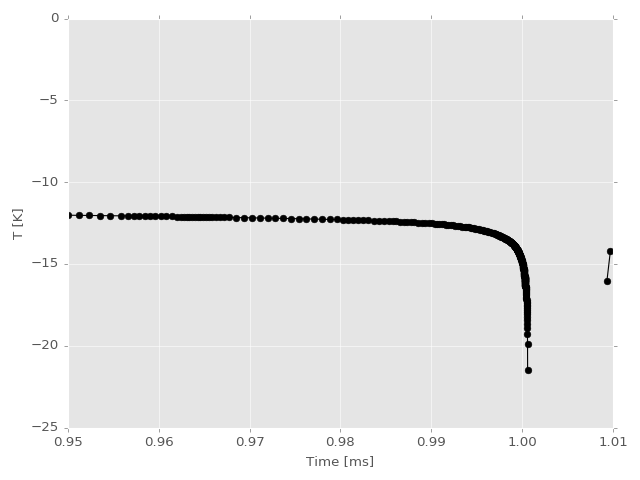

C:\Anaconda3\lib\site-packages\ipykernel\__main__.py:54: RuntimeWarning: invalid value encountered in log


In [6]:
pd.options.display.float_format = '{:,.2e}'.format

gas.TPX = temp, pres, COMP
r = ct.IdealGasReactor(gas)
sim = ct.ReactorNet([r])

# enable sensitivity with respect to the rates of the first 10
# reactions (reactions 0 through 9)
for i in range(m):
	r.add_sensitivity_reaction(i)

# set the tolerances for the solution and for the sensitivity coefficients
sim.rtol = 1.0e-6
sim.atol = 1.0e-15
sim.rtol_sensitivity = 1.0e-6
sim.atol_sensitivity = 1.0e-6

sens_T = []
states = ct.SolutionArray(gas, extra=['t'])

t_end = 10.0
time = []
temperature = []

while sim.time < ign0*1.5 and r.T < T_equi + 0.1:
	sim.step()
	sens_T.append( sim.sensitivities()[2+5,:] )
	states.append(r.thermo.state, t=sim.time)
	
	time.append( sim.time )
	temperature.append( r.T )
#	 print(sim.time)
	
print( sim.time*1000, ign0*1000 )
# print(sens_T)

time = np.array( time )
temperature = np.array( temperature )

sens_T = np.array( sens_T )
diff_temp = np.diff(temperature)/np.diff(time)
ign_pos = np.argmax(diff_temp)

# Return the log10 normal ignition delay
ign = time[ign_pos]

ign_T = temperature[ign_pos]

print(ign_T)

plt.figure()
# plt.xlim((0.15, 0.30))
#plt.plot(states.t*1000, temperature)
plt.plot(states.t[:-1]/ign0, np.log(sens_T[0:-1, 9]/np.array(diff_temp)), '-ok')
plt.xlabel('Time [ms]')
plt.ylabel('T [K]')
plt.xlim( 0.95, 1.01 )
#plt.ylim( -0.001,0.001 )
plt.tight_layout()
plt.show()

for i in range(m):
	sensitivities["adjoint"][i] = -sens_T[ign_pos,i]
	sensitivities["ratio"][i] = sensitivities["bruteforce"][i] /(sensitivities["adjoint"][i] + 1.E-30)
	sensitivities['index'][i] = i

sensitivities = sensitivities.sort_values( 'bruteforce' )
# sensitivities.head()
# print( sensitivities.to_string(index=True) )

In [7]:
sensitivities.head(10)

,index,bruteforce,adjoint,ratio
H + O2 <=> O + OH,9,-1.40e+00,-4.33e+03,3.23e-04
H + H2O2 <=> H2 + HO2,17,-4.22e-01,-1.32e+03,3.20e-04
2 OH (+M) <=> H2O2 (+M),20,-3.59e-01,-1.13e+03,3.17e-04
H + HO2 <=> 2 OH,16,-1.23e-01,-3.76e+02,3.27e-04
H + HO2 <=> H2 + O2,15,-6.06e-02,-1.95e+02,3.11e-04
H2 + OH <=> H + H2O,19,-3.49e-02,-1.11e+02,3.15e-04
H2 + O <=> H + OH,2,-2.72e-02,-8.64e+01,3.15e-04
H + HO2 <=> H2O + O,14,-5.32e-03,-1.63e+01,3.25e-04
2 HO2 <=> H2O2 + O2,25,-6.16e-05,2.55e-01,-2.41e-04
2 O + M <=> O2 + M,0,-2.41e-05,3.03e-03,-7.95e-03


In [8]:
sensitivities.tail(10)

,index,bruteforce,adjoint,ratio
H + H2O2 <=> H2O + OH,18,1.70e-03,5.02e+00,3.39e-04
H2O2 + O <=> HO2 + OH,4,2.25e-03,6.85e+00,3.29e-04
HO2 + OH <=> H2O + O2,27,3.94e-03,1.19e+01,3.31e-04
H2O2 + OH <=> H2O + HO2,24,9.87e-03,2.99e+01,3.30e-04
HO2 + OH <=> H2O + O2,22,1.58e-02,4.81e+01,3.29e-04
HO2 + O <=> O2 + OH,3,1.65e-02,5.08e+01,3.25e-04
H + H2O + O2 <=> H2O + HO2,7,1.77e-02,5.36e+01,3.30e-04
H + 2 O2 <=> HO2 + O2,6,2.40e-01,7.33e+02,3.27e-04
H + O2 + M <=> HO2 + M,5,4.77e-01,1.47e+03,3.25e-04
AR + H + O2 <=> AR + HO2,8,6.85e-01,2.12e+03,3.24e-04


In [9]:
print( sensitivities.to_string(index=True) )

                           index bruteforce   adjoint     ratio
H + O2 <=> O + OH              9  -1.40e+00 -4.33e+03  3.23e-04
H + H2O2 <=> H2 + HO2         17  -4.22e-01 -1.32e+03  3.20e-04
2 OH (+M) <=> H2O2 (+M)       20  -3.59e-01 -1.13e+03  3.17e-04
H + HO2 <=> 2 OH              16  -1.23e-01 -3.76e+02  3.27e-04
H + HO2 <=> H2 + O2           15  -6.06e-02 -1.95e+02  3.11e-04
H2 + OH <=> H + H2O           19  -3.49e-02 -1.11e+02  3.15e-04
H2 + O <=> H + OH              2  -2.72e-02 -8.64e+01  3.15e-04
H + HO2 <=> H2O + O           14  -5.32e-03 -1.63e+01  3.25e-04
2 HO2 <=> H2O2 + O2           25  -6.16e-05  2.55e-01 -2.41e-04
2 O + M <=> O2 + M             0  -2.41e-05  3.03e-03 -7.95e-03
2 H + H2 <=> 2 H2             11   7.84e-06  2.88e-02  2.72e-04
2 OH <=> H2O + O              21   3.83e-05  3.67e-03  1.05e-02
2 H + H2O <=> H2 + H2O        12   4.86e-05  1.13e-02  4.30e-03
H + O + M <=> OH + M           1   4.99e-05  1.47e-02  3.40e-03
2 H + M <=> H2 + M            10   5.27e

<IPython.core.display.Javascript object>


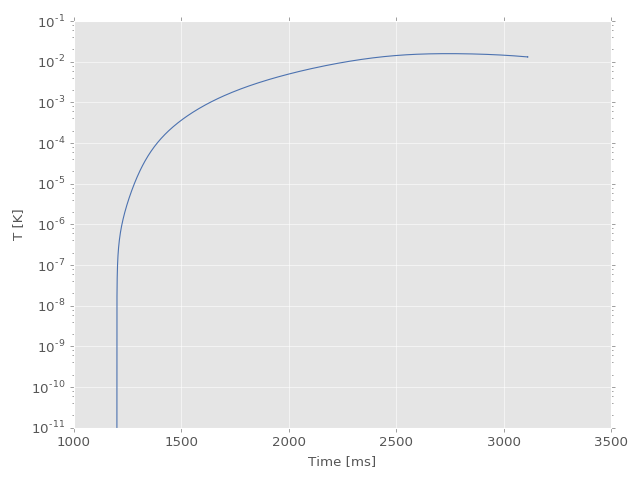

In [10]:
plt.figure()
# plt.xlim((0.15, 0.30))
# plt.plot(states.t*1000, temperature)
# plt.semilogy(states.t*1000, states.Y[:,4])
plt.semilogy(states.T, states.Y[:,4])
# plt.xlim( 0, ign0*1000*1.5 )
plt.ylim( 1.E-11, 1.E-1 )
plt.xlabel('Time [ms]')
plt.ylabel('T [K]')
plt.tight_layout()
plt.show()

In [11]:
print(max(temperature))

3113.74329667


In [12]:
# sensitivities["adjoint_1"] = ""
# sensitivities["ratio_1"] = ""

# start_index = np.argmin( np.absolute(temperature - temp - 470) )
# end_index = np.argmin( np.absolute(temperature - T_equi + 730) )

# delta_sens_T = np.dot( sens_T[start_index:end_index,:].transpose(), np.diff(time)[start_index:end_index])

# print( delta_sens_T.shape )

# for i in range(m):
#	 sensitivities["adjoint_1"][i] = - np.mean( sens_T[start_index:end_index,i] )
#	 sensitivities["ratio_1"][i] = sensitivities["bruteforce"][i] /sensitivities["adjoint_1"][i]

# print( start_index,ign_pos, end_index, temperature[start_index], temperature[ign_pos], temperature[end_index] )	

# sensitivities.head()

In [13]:
np.multiply( temperature, time )

print( gas.n_reactions )

28


In [14]:
# # Reaction mechanisms can contains thousands of elementary steps. Choose a threshold
# # to see only the top few
# threshold = 1e-1

# firstColumn = sensitivities.columns[0]

# # For plotting, collect only those steps that are above the threshold
# # Otherwise, the y-axis gets crowded and illegible
# plt.rcParams.update({'ytick.labelsize': 8})

# sensitivitiesSubset = sensitivities[sensitivities[firstColumn].abs() > threshold]
# indicesMeetingThreshold = sensitivitiesSubset[firstColumn].abs().sort_values(ascending=False).index
# sensitivitiesSubset[sensitivities.columns[0:2]].loc[indicesMeetingThreshold].plot.barh(title="Sensitivities for GRI 3.0",
#														   legend=[True])
# plt.gca().invert_yaxis()
# plt.rcParams.update({'axes.labelsize': 16})
# plt.xlabel(r'Sensitivity: $\frac{\partial\:\ln{\tau_{ign}}}{\partial\:\ln{k}}$');

# sensitivitiesSubset.loc[indicesMeetingThreshold]

In [21]:
sim.sensitivity_parameter_name(0)

'IdealGasReactor_53: 2 O + M <=> O2 + M'

In [28]:
"""
Viewing a reaction path diagram.

This script uses Graphviz to generate an image. You must have Graphviz installed
and the program 'dot' must be on your path for this example to work.
Graphviz can be obtained from http://www.graphviz.org/ or (possibly) installed
using your operating system's package manager.
"""

import os
import sys

import cantera as ct

# these lines can be replaced by any commands that generate
# an object of a class derived from class Kinetics in some state.
gas = ct.Solution('gri30.xml')
gas.TPX = 1000.0, 20*ct.one_atm, 'CH4:0.5, O2:1, N2:3.76'
r = ct.IdealGasReactor(gas)
net = ct.ReactorNet([r])
T = r.T
while T < 2426:
    net.step()
    T = r.T

print(net.time)
element = 'C'

diagram = ct.ReactionPathDiagram(gas, element)
diagram.title = 'Reaction path diagram following {0}'.format(element)
diagram.show_details = True
diagram.label_threshold = 0.1

dot_file = 'rxnpath.dot'
img_file = 'rxnpath.png'
img_path = os.path.join(os.getcwd(), img_file)

diagram.write_dot(dot_file)
print(diagram.get_data())

print("Wrote graphviz input file to '{0}'.".format(os.path.join(os.getcwd(), dot_file)))

os.system('dot {0} -Tpng -o{1} -Gdpi=200'.format(dot_file, img_file))
print("Wrote graphviz output file to '{0}'.".format(img_path))

if "-view" in sys.argv:
    import webbrowser
    webbrowser.open('file:///' + img_path)

0.03842309601840947
Reaction path diagram following C
CH CO CH2 HCO CH2(S) CH3 CH2O CH4 CO2 CH2OH CH3O CH3OH C2H C2H2 HCCO C2H3 CH2CO C2H4 C2H5 C2H6 C HCCOH CN NCO HCN HOCN HNCO H2CN HCNN HCNO CH2CHO CH3CHO C3H8 C3H7 
CH CO 30.9139 -3.99148e-09
CH CH2 761.341 -3379.99
CH HCO 1936.86 -0.000296618
CH CH2(S) 7.52539 -50.5255
CH CH3 21.1972 -4.56984
CH CH2O 511.435 -0.149993
CH CH4 0 -0
CH CO2 0 -0
CH CH2OH 0 -0
CH CH3O 0 -0
CH CH3OH 0 -0
CH C2H 0.000216447 -18.2177
CH C2H2 3.89021 -3.82748e-06
CH HCCO 28.1817 -197.269
CH C2H3 17.5682 -0.0273338
CH CH2CO 19.8452 -0.0393723
CH C2H4 57.2689 -0.158732
CH C2H5 0 -0
CH C2H6 0 -0
CH C 230.873 -6.34527
CH HCCOH 0 -0
CH CN 0 -0
CH NCO 0.0340209 -1.22572e-06
CH HCN 16.0287 -0.000130528
CH HOCN 0 -0
CH HNCO 0 -0
CH H2CN 0 -0
CH HCNN 24.8957 -20.4624
CH HCNO 0 -0
CH CH2CHO 0 -0
CH CH3CHO 0 -0
CH C3H8 0 -0
CH C3H7 0 -0
CO CH2 0 -1015.17
CO HCO 500.211 -14378.2
CO CH2(S) 8.39351e-08 -1301.05
CO CH3 0 -2671.31
CO CH2O 0.00214067 -27.5131
CO CH4 0 -0
CO 

In [34]:
sim.sensitivities().shape

(12, 28)